# **Kmeans-Dbscan Segmentation Notebook**

---
# **How to Run Notebook**
---


1. Set up `virtual conda environment` if you have not already done so. Uncomment to run.

In [ ]:
# !conda create conda create ../environments/environment.yml --no-builds

In the code editor running this Jupyter Notebook, change the kernel to the new `TILSEG_PROJECT2024` conda environment. THis will allow you to use the needed imports.

2. Update the `respository_path` variable to use the 'TILSEG_PROJECT2024' Cloned Github Folder path. 
This path is needed to access the example files used in the notebook.

In [1]:
import os
directory_path = os.getcwd()
repository_path = os.path.dirname(directory_path)

3. Run the `Initalization Block`. This is necessary as Python adds a directory for this notebook to the list of locations where modules can be searched from when importing.

In [2]:
import sys
sys.path.append(repository_path)

4. Import the needed modules in the `Import Block`

In [3]:
# External library imports
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

#Local Library Imports
from tilseg.preprocessing import preprocess
from tilseg.seg import segment_TILs
from tilseg.model_selection import opt_kmeans
from tilseg.refine_kmeans import KMeans_superpatch_fit
from tilseg.refine_kmeans import kmean_to_spatial_model_patch_wrapper
from tilseg.refine_kmeans import kmean_to_spatial_model_superpatch_wrapper

5. Data download block. Used to install the `gdown` module to access data from google drive. Uncoment to run, but you only need to run this once per laptop.

In [1]:
# !pip install gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 3.6 MB/s eta 0:00:00a 0:00:01


### **Current repository contains the following file strucutre of the `Example` Folder:**
#### These files will be used to walk through an example of using TILSEG_PROJECT2024 in analysis.<br>
<img src= "Notebook_Images/Image_9.png" style="width: 400px;"><br>
#### The Notebook_Images folder is used to fill the notebook with the different pictures used in the walkthrough.

---
# **Core Features Overview**
---

### The TILSEG_PROJECT2024 software package is intended for use in breast cancer slide segmentation analysis, aimed at accelerating breast cancer detection. This package consists for 4 main components:

## From 2023 Capstone (OLD COMPONENTS):
### 1. <u>Preprocessing (preprocessing.py):</u>
<img src= "Notebook_Images/image_7.png" style="width: 600px;">
<img src= "Notebook_Images/image_8.png" style="width: 597px;">

#### creates superpatch .tif file from cropped 3000 by 4000 pixel patches from a stained breast cancer slide. The original image is segmented into all possible patches where a select number (default: 6) are chosen that represent different sections of grays scales from a guassian distribution. 

#### Sub-Components:
* #### test
<br>
<span style="background-color: rgba(255, 255, 0, 0.5); font-size: 20px;">UPDATES/BUG FIXES FROM 2024 PROJECT: </span>

* #### Changed the os handling to read in the full filepaths of each .svs image since the original code was using only the filename (this led to filepath exception errors)
* #### def get_superpatch_patches (def preprocess << def get_superpatch_patches) updated to now have a random state argument to allow for the superpatch to be made from the same patches each time a notebook is run
* #### def sort_patches (def preprocess << def main_preprocessing << def sort_patches) was updated to use a Gaussian Mixture distribution to identify the peaks associated with the pink tissue and white background to reduce the background in the returned superpatches. Original method was documented very poorly and did not accurately remove white background patches, as shown below.

    | Superpatch - Old Sort Patches Function   | Superpatch - New Sort Patches Function  |
    |--------------|--------------|
    | <img src= "Notebook_Images/super_before.png" style="width: 570px;"> | <img src= "Notebook_Images/image_8.png" style="width: 570px;">|



### 2. <u>Image Segmentation (seg.py >> def segment_TILs) </u>
#### Applies a clustering model (e.g. KMeans) on a superpath and applies the model to a folder of patches to generate the following files: TILs overlayed on the original H&E patch, binary segmentation masks of each cluster, individual clusters overlayed on the original patch, image of all the clusters, and a CSV file containing countour information of each TIL segmented from the patch. Currently accepts fitted and non-fitted 'KMeans', 'DBSCAN', 'OPTICS', 'BIRCH' algorithms.

#### Sub-Components:
* #### def image_postprocessing
<br>
<span style="background-color: rgba(255, 255, 0, 0.5); font-size: 20px;">UPDATES/BUG FIXES FROM 2024 PROJECT: </span>

* #### def segment_TILS was updated to take in a `multiple_images` flag to be able to be able to fit a kmeans model to a patch rather than just a superpatch to use the predicted clusters on this patch in downstream scoring

* #### def immune_cluster_analyzer (def segment_TILS << def image_postprocessing << def immune_cluster_analyzer) was updated to return the `cluster mask` of the highest TIL contour count to be able to do further segmenetation using dbscan (explained in next section)

* #### def draw_til_images (def segment_TILS << def image_postprocessing << def draw_til_images) had a bug for a wrong array type fed to .drawContours package that was fixed

* #### def segment_TILS had a bug fixed to only check for .tif images in a patches folder (avoid errors of hidden .ipynb or files)

## From 2024 Software Project (NEW COMPONENTS):

### 3. <u>Spatial Modeling (refine_kmeans.py >> def kmean_to_spatial_model wrappers) </u>
#### Created wrappers to run def segment_TILS on a folder of patches and use the output kmeans labels of the highest contour cluster to do further clustering with dbscan. Similarily, a wrapper was created to run segment_TILS on a single patch as both the superpath and patch to run dbscan on-itself and generate a ground truth scoring dbscan classification on the cluster.

#### Sub-Components:
* #### mask_to_features
* #### km_dbscan_wrapper


### 4. <u>Bug Fixes from Original Code</u>

---
# **Example Walkthrough**
---

## A) Pre-Preprocessing Step on a Slide Image
### This section will show you how to utilize the preprocessing functions to construct a superpatch and a folder of associated slide patches.

#### 1. To begin, download a sample Raw Slide Image (.Svs) by running the block below. This file is stored in a public Google Drive, as the filesize is too large to upload to Github.

In [5]:
!mkdir Image_Files
!gdown 'https://drive.google.com/uc?id=1_aR-Vwd0B3suQW214zfkLudl6HK3w4q3' -O "Image_Files/TCGA-A2-A0CW-01Z-00-DX1.svs"

Downloading...
From (original): https://drive.google.com/uc?id=1_aR-Vwd0B3suQW214zfkLudl6HK3w4q3
From (redirected): https://drive.usercontent.google.com/download?id=1_aR-Vwd0B3suQW214zfkLudl6HK3w4q3&confirm=t&uuid=a847f24a-4946-46e6-ad75-d708fb1dd41a
To: /Users/laurenfrank/TilsegV2/Example/Image_Files/TCGA-A2-A0CW-01Z-00-DX1.svs
100%|████████████████████████████████████████| 667M/667M [00:23<00:00, 28.0MB/s]


##### A Slide Image (.svs) should have been saved to a new Folder called `Image_Files`. This file will be used in the next step.
<img src= "Notebook_Images/Image_4.png" style="width: 165px;">, <span style="font-size: 6em;">&rarr;</span> <img src= "Notebook_Images/image_5.png" style="width: 170px;">

#### 2. Create the Superpatch and Patch Images Using the `Preprocess` Function in `Tilseg.Processing` Module
- #### Using the .svs image, the preprocess function will create a superpatch using 6 of the total patches. Feel free to experiment with a different patch sizes (e.g. 3, 9, 12, ...) to see how this affects the superpatch.
- #### Random state of 13 was specified to make notebook consistent between runs
- #### The filepath of the .svs image will be printed along with the amount of pixels lost during the patch making phase
- #### NOTE: `preprocess` can be used on a folder of .svs images rather than just the one slide image (what was done in this example), but this will significantly increase the run time. When using multiple images, still only one superpatch would be made, but it would be made of (num_patches * num_csv_images) patches (e.g. 6 patches * 2 .csv images = 12 patches in superpatch)

In [6]:
path = repository_path + '/Example/Image_Files'
superpatch = preprocess(path, patches=6, training=True, save_im=True,random_state = 13)

/Users/laurenfrank/TilsegV2/Example/Image_Files/TCGA-A2-A0CW-01Z-00-DX1.svs
Percent of pixels lost in pre-processing for TCGA-A2-A0CW-01Z-00-DX1.svs:                       1.7593642775049286e-06 %


| Before     | After    |
|--------------|--------------|
| <img src= "Notebook_Images/Image_4.png" style="width: 165px;">, <span style="font-size: 6em;">&rarr;</span> <img src= "Notebook_Images/image_5.png" style="width: 170px;"> | <img src= "Notebook_Images/Image_4.png" style="width: 170px;">, <span style="font-size: 6em;">&rarr;</span> <img src= "Notebook_Images/image_6.png" style="width: 500px;"> |


#### 3. Creates Three_Patches_Example Folder & Single_Patch_Example Folders and Move Patches to these Folders

#### - For sake of time, only three images from the created folder "TCGA-A2-..." will be used in model construction. The 3 patches chosen had a good ratio of pink (breast tissue) to slide background (white), which will be useful in downstream analysis:
* #### position_7_8tissue.tif
* #### position_14_20tissue.tif
* #### position_6_16tissue.tif

#### - Run the below block to construct these two folders in addition to Sub Result Folders

In [7]:

!mkdir Image_Files/Three_Patches_Example
!mv Image_Files/TCGA-A2-A0CW-01Z-00-DX1/position_7_8tissue.tif Image_Files/TCGA-A2-A0CW-01Z-00-DX1/position_14_20tissue.tif Image_Files/TCGA-A2-A0CW-01Z-00-DX1/position_6_16tissue.tif Image_Files/Three_Patches_Example

!mkdir Image_Files/Single_Patch_Example
!cp Image_Files/Three_Patches_Example/position_7_8tissue.tif Image_Files/Single_Patch_Example/position_7_8tissue.tif

#### Inside the `Image_Files` Folder you should see:

<img title="a title" alt="Alt text" src="Notebook_Images/image_10.png" width="180">  
<span style="font-size: 6em;">&rarr;</span>
<img title="a title" alt="Alt text" src="Notebook_Images/image_11.png" width="440"><br>
<img title="a title" alt="Alt text" src="Notebook_Images/image_13.png" width="180">
<span style="font-size: 6em;">&rarr;</span>
<img title="a title" alt="Alt text" src="Notebook_Images/image_14.png" width="180"><br>


#### 4. Create a `Results` folder inside `Example` to have a location to save data to after completing the different exercises. This will also create 4 nested-folders inside `Results` corresponding to the names of these exercises. 

In [11]:
!mkdir Results
!mkdir Results/Image_Seg_Case_i
!mkdir Results/Image_Seg_Case_ii
!mkdir Results/Dbscan_Case_i
!mkdir Results/Dbscan_Case_ii

#### Inside the `Results` Folder you should see:<br>

<img title="a title" alt="Alt text" src="Notebook_Images/image_21.png" width="175">
<span style="font-size: 6em;">&rarr;</span>
<img title="a title" alt="Alt text" src="Notebook_Images/image_20.png" width="610"> 

## B) Image Sementation
### This section will walk through how to use the segmentation functions to train a kmeans model on a superpatch or test the ground-truth prediction of a single patch.

### Case i: Running Segment_TILS on a Single Patch

#### 1. In Section A, a single patch was saved to the `Single_Patch_Example` Folder. This will file will be used in the demonstration of the Single Patch Functions.

#### `position_7_8tissues.tif`<br>
<img src= "Notebook_Images/image_12.png" style="width: 600px;">

#### 2. Open the Patch Image and Normalize the Pixels

In [12]:
patch_path = repository_path + '/Example/Image_Files/Single_Patch_Example/position_7_8tissue.tif'
img = Image.open(patch_path)
numpy_img = np.array(img)
numpy_img_reshape = np.float32(numpy_img.reshape((-1, 3))/255.)

#### 3. Optimize the Kmeans Model on Patch (Almost always 4 clusters)

In [13]:
hyperparameter_dict = opt_kmeans(numpy_img_reshape,n_clusters = [2,3,4,6,7,8,9,10])
kmeans_fit = KMeans_superpatch_fit(patch_path,hyperparameter_dict, random_state = 13)

#### 4. Run segment_TILS
* ##### Since we will be running the segmentation on a single patch, we will set the multiple_images flag = False. This also means that the in_dir_path should only be the path to the patch rather than to a folder of patches, as we will show in the next case.
* ##### It should be noted that segment_TILS can also create/fit a model when passed in a hyperparameter dict and algorithm type; however, since the `KMeans_superpatch_fit` already returns a fitted model, this feature was bypassed via the `model` argument. If you chose to use it, you would put None into the `model` argument and feed the parameters into the `hyperparameter_dict` argument.
* ##### Lastly, this notebook was inteded to showcase the implementation of KMeans-Dbscan, so only KMeans was used. However, this function can be fed KMeans, DBSCAN, BIRCH, or OPTICS models - not just KMeans.

In [14]:
TIL_count_dict, kmean_labels_dict, cluster_mask_dict, cluster_index_dict = segment_TILs(in_dir_path = patch_path,
                                                        out_dir_path = repository_path + '/Example/Results/Image_Seg_Case_i',
                                                        hyperparameter_dict = None,
                                                        algorithm = 'KMeans',
                                                        model = kmeans_fit,
                                                        save_TILs_overlay = True,
                                                        save_cluster_masks = True,
                                                        save_cluster_overlays = True,
                                                        save_all_clusters_img = True,
                                                        save_csv = True,
                                                        multiple_images = False)

#### In the above block, a kmeans model was fitted and predicted on the single patch. This type of function can be used to validate the results from a superpatch fitted model onto this patch - this will be done in case ii.

#### 5. Exploring the Output

In [15]:
for i,key in enumerate(kmean_labels_dict):
    print(f'File {i+1}')
    print(f'Filepath: {key}') 
    print(f'First 30 Cluster Labels: {kmean_labels_dict[key][:30]}')
    print(f'Unique Labels: {set(kmean_labels_dict[key])}')
    print(f'Cluster label number that had the most contours: {cluster_index_dict[key]}')
    print(f'TIL_count of cluster {cluster_index_dict[key]}: {TIL_count_dict[key]}')

File 1
Filepath: position_7_8tissue
Cluster Labels: [0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 3 3 3 3]
Unique Labels: {0, 1, 2, 3}
Cluster label number that had the most contours: 1
TIL_count of cluster 1: 2742


#### As you can see above, this image was found to have 4 optimzed clusters (0,1,2,3) and cluster 1 has the most TIL contours of 2742! Moreover, the clustering and contour map plots can be found in the `Clustering` Folder in `Results/Image_Seg_Case_i`

<img title="a title" alt="Alt text" src="Notebook_Images/Image_1.png" width="200">  
<span style="font-size: 6em;">&rarr;</span>
<img title="a title" alt="Alt text" src="Notebook_Images/image_2.png" width="200">
<span style="font-size: 6em;">&rarr;</span>
<img title="a title" alt="Alt text" src="Notebook_Images/image_16.png" width="600">

#### When zoomed in on the `AllClusters.jpg`, `ContourMask.jpg`, and `ContourOverlap.jpg` you can see:

<img title="a title" alt="Alt text" src="Notebook_Images/image_17.png" width="400">
<img title="a title" alt="Alt text" src="Notebook_Images/image_18.png" width="400">  
<img title="a title" alt="Alt text" src="Notebook_Images/image_19.png" width="400">  

#### The KMeans clusters can be seen in the first image, while the binary mask/contour map of cluster 1 can be seen in the second image (the pink cluster with the large contours removed). This cluster was then overlaid the original raw image in the third figure.

### Case ii: Running Segment_TILS on a Folder of Patches

#### 1. Like in Case i, the images placed into the `Three_Patches_Example` Folder will now be used for analysis with the Multiple Image Functions.

#### `position_7_8tissues.tif`, `position_7_8tissues.tif`, `position_7_8tissues.tif` <br>
<img src= "Notebook_Images/image_15.png" style="width: 700px;">

#### 2. Open the Superpatch Image and Normalize the Pixels

In [4]:
superpatch_path = repository_path + '/Example/Image_Files/superpatch_training.tif'
img = Image.open(superpatch_path)
numpy_img = np.array(img)
numpy_img_reshape = np.float32(numpy_img.reshape((-1, 3))/255.)

#### 3. Optimize the Kmeans Model on Patch (Almost always 4 clusters)

In [5]:
hyperparameter_dict = opt_kmeans(numpy_img_reshape,n_clusters = [2,3,4,6,7,8,9,10])
kmeans_fit = KMeans_superpatch_fit(superpatch_path,hyperparameter_dict,random_state = 13)

#### 4. Run segment_TILS
* ##### Since we will be running the segmentation on a folder of patches, we will set the multiple_images flag = True. This also means that the in_dir_path should be the path to the direcctory of patches (unlike before where it was just the path to the single image)
* #### In case ii, the superpatch is used to fit a KMeans model that is then fed into the segment_TILS function and predicted ontop of the separate patches in the folder. As discussed before, we will compare the clustering results of `position_7_8tissues.tif' with case i and case ii how case i is useful.

In [9]:
directory_path = repository_path + '/Example/Image_Files/Three_Patches_Example'
TIL_count_dict, kmean_labels_dict, cluster_mask_dict, cluster_index_dict = segment_TILs(in_dir_path = directory_path,
                                                        out_dir_path = repository_path + '/Example/Results/Image_Seg_Case_ii',
                                                        hyperparameter_dict = None,
                                                        algorithm = 'KMeans',
                                                        model = kmeans_fit,
                                                        save_TILs_overlay = True,
                                                        save_cluster_masks = True,
                                                        save_cluster_overlays = True,
                                                        save_all_clusters_img = True,
                                                        save_csv = True,
                                                        multiple_images = True)

#### 5. Exploring the Output

In [13]:
for i,key in enumerate(kmean_labels_dict):
    print(f'File {i+1}')
    print(f'Filename: {key}') 
    print(f'First 30 Cluster Labels: {kmean_labels_dict[key][:30]}')
    print(f'Unique Labels: {set(kmean_labels_dict[key])}')
    print(f'Cluster label number that had the most contours: {cluster_index_dict[key]}')
    print(f'TIL_count of cluster {cluster_index_dict[key]}: {TIL_count_dict[key]}')

File 1
Filename: position_6_16tissue
First 30 Cluster Labels: [2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Unique Labels: {0, 1, 2, 3}
Cluster label number that had the most contours: 2
TIL_count of cluster 2: 1730
File 2
Filename: position_7_8tissue
First 30 Cluster Labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0]
Unique Labels: {0, 1, 2, 3}
Cluster label number that had the most contours: 3
TIL_count of cluster 3: 2865
File 3
Filename: position_14_20tissue
First 30 Cluster Labels: [2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Unique Labels: {0, 1, 2, 3}
Cluster label number that had the most contours: 0
TIL_count of cluster 0: 977


#### As before, the clustering and contour map plots for each .tif ile can be found in the `Clustering` Folders in `Results/Image_Seg_Case_ii`

<img src= "Notebook_Images/image_22.png" style="width: 700px;"><br>

#### Feel free to explore the output files of each cluster, but they should be the same exact file types (AllClusters.jpg, ContourMask.jpg, ContourOverlap.jpg) as in case i but now for each .tif file. We will now focus our analysis to the `ContourOverlap.jpg` produced by `position7_8tissue` in case i and case ii.

## C) Spatial Modeling
### This section will walk through how to to train a kmeans model on a superpatch / test the ground-truth prediction of a single patch and feed these results into a dbscan model to further segment the high contour count cluster.

### Case i: Running kmean_to_spatial_model_patch_wrapper on a Single Patch

#### 1. Run the patch version of the wrapper that takes in the filepath of the patch. Currently, there is no hyperarameter optimization for DBSCAN as it takes several hours to complete just a few parameters, so default values of `patial_hyperparameters = {'eps': 15,'min_samples': 100}` were used.

* #### It should be noted that the wrapper optimizes, fits, and predicts kmeans while also running segment TILS all inside this one wrapper function. This is why there is not need to normalize the image, hyperparameterize, and fit the kmeans model in separate cells like what was done in Section B.

Completed Kmeans fitting.


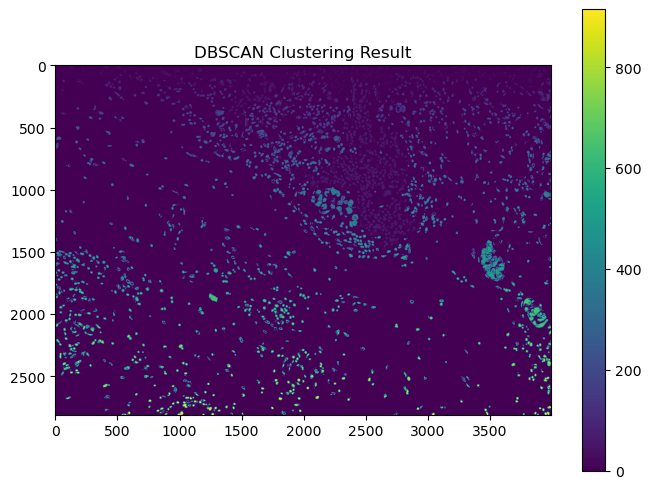

Script completed. Dbscan fitting time: 16.092634677886963 seconds.


In [4]:
patch_path = repository_path + '/Example/Image_Files/Single_Patch_Example/position_7_8tissue.tif'
im_labels, dbscan_model, cluster_mask_dict, cluster_index = kmean_to_spatial_model_patch_wrapper(patch_path = patch_path,
                        spatial_hyperparameters = {'eps': 15,'min_samples': 100},
                        n_clusters = [1,2,3,4,5,6,7,8,9],
                        out_dir_path = repository_path + '/Example/Results/Dbscan_Case_i',
                        save_TILs_overlay = True,
                        save_cluster_masks = True,
                        save_cluster_overlays = True,
                        save_all_clusters_img = True,
                        save_csv = True,
                        random_state = 13)

#### 2. Explore the Output

In [14]:
reshaped_im_labels = im_labels.reshape(1,-1)
print(f'Kmeans Cluster label number that had the most contours: {cluster_index}')
print(f'\nUnique DBSCAN Cluster Labels: {np.unique(reshaped_im_labels)}\n')

Kmeans Cluster label number that had the most contours: 1

Unique DBSCAN Cluster Labels: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 22

### Case ii: Running kmean_to_spatial_model_superpatch_wrapper on a Folder of Patches

#### 1. Run the superpatch version of the wrapper that takes in the filepath of the superpatch and in directory to patches. The default hyperparameters for DBSCAN in case i were used again.

* #### Since the hyperparameters are highly dependent on the spatial information of the cluster inside the patch, and we do not currently have an optimize function, the `Single_Patch_Example` folder was used instead as it only contains the `position_7_8tissue`. However, despite this folder only containing one image, it still demonstrates how the function works. 

Found hyperparameters. Time took: 3.2386139313379925 minutes.
Completed Kmeans fitting. Time took: 0.7304865678151449 minutes.
Dbscan fitting time for file position_7_8tissue.tif: 18.28687572479248 seconds.


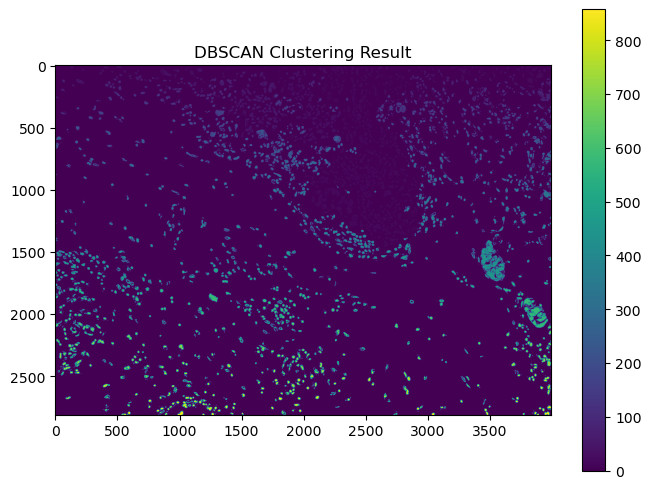

In [4]:

im_labels, dbscan_model, cluster_mask_dict, cluster_index_dict = kmean_to_spatial_model_superpatch_wrapper(superpatch_path = repository_path + '/Example/Image_Files/superpatch_training.tif',
                                            in_dir_path = repository_path + '/Example/Image_Files/Single_Patch_Example',
                                            spatial_hyperparameters= {'eps': 15,'min_samples': 100},
                                            n_clusters = [1,2,4,5,6,7,8,9],
                                            out_dir_path = repository_path + '/Example/Results/Dbscan_Case_ii',
                                            save_TILs_overlay = True,
                                            save_cluster_masks = True,
                                            save_cluster_overlays =  True,
                                            save_all_clusters_img = True,
                                            save_csv = True,
                                            random_state = 13)

CLustering Results should have been saved to the `Results` Folder

<img title="a title" alt="Alt text" src="Notebook_Images/Image_1.png" width="200">  
<span style="font-size: 6em;">&rarr;</span>
<img title="a title" alt="Alt text" src="Notebook_Images/image_2.png" width="200">
<span style="font-size: 6em;">&rarr;</span>
<img title="a title" alt="Alt text" src="Notebook_Images/image_3.png" width="600">

### BREAK